# Banana Ripeness Classification

## Image preparation

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Removing invalid images

In [3]:
import cv2
import imghdr

/var/folders/71/z1p57v9j3xx9mtyxfmr4bw5m0000gn/T/ipykernel_11696/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [31]:
data_dir = 'data'
os.listdir(data_dir)
# os.listdir(os.path.join(data_dir, 'unripe'))

['.DS_Store', 'unripe', 'ripe']

In [32]:
# Image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [38]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):
        for image in os.listdir(class_path):
            if image == '.DS_Store':
                continue  # Skip .DS_Store files
            image_path = os.path.join(class_path, image)
            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print("Image not in ext list: {}".format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print("Issue with image {}: {}".format(image_path, e))
                os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


### Load data

In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# Create a dataset of those images using keras utils (building our data pipeline)
data = tf.keras.utils.image_dataset_from_directory('data')

Found 322 files belonging to 2 classes.


In [9]:
# Create a data iterator -> allow us to access the data pipeline
data_iterator = data.as_numpy_iterator()

2024-03-13 13:00:52.778863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]
2024-03-13 13:00:52.779106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]


In [10]:
# Get a batch of data from the data pipeline
batch = data_iterator.next()

2024-03-13 13:00:53.104388: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-13 13:00:53.651883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


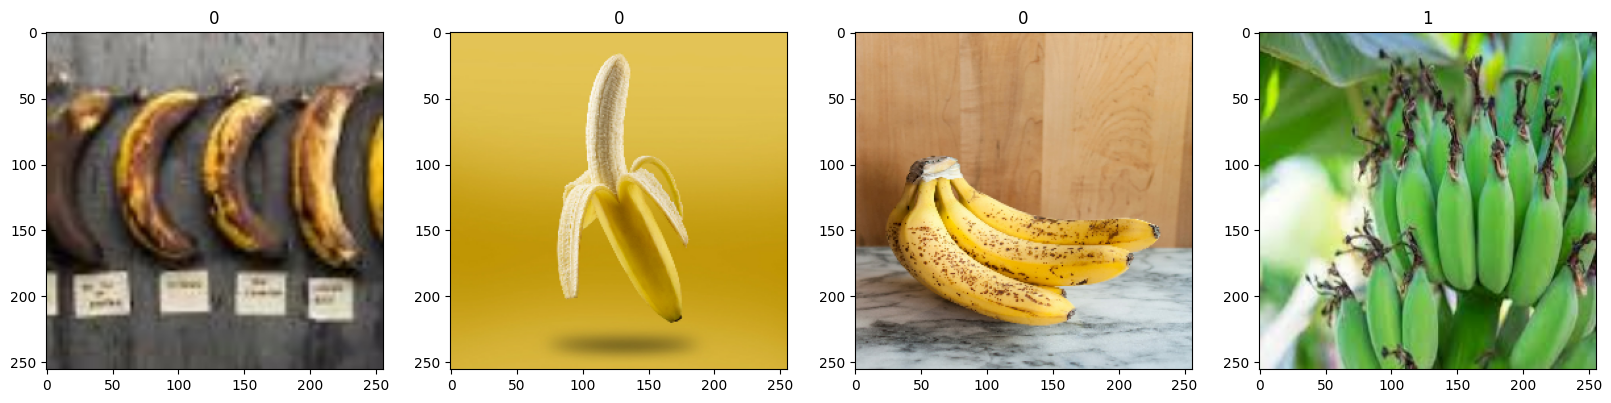

In [40]:
# Visualize a batch 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Based on this batch, 0 represents the ripe bananas and 1 represents the unripe bananas.


CLASS 1 = UNRIPE 
CLASS 0 = RIPE

## Scaling data

Now we need to scale our images into a standard size (255, 255) before using them to train our neural network model

In [5]:
# Divide the image size by 255 while keep the label (y) the same
data = data.map(lambda x, y: (x/255, y))

In [13]:
# Iterate
scaled_iterator = data.as_numpy_iterator()

2024-03-13 13:01:00.939904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]
2024-03-13 13:01:00.940283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]


In [14]:
# Access the image that's scaled from 0 to 1 instead of 0 to 255. 
scaled_batch = scaled_iterator.next()

2024-03-13 13:01:02.245431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 13:01:02.628087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


## Split data

In [15]:
len(data)

11

Our data has 11 batches with each batch containing 29 images and the final batch will contain 32 images for the total batches to contain exactly 322 image files

Let's split the data into three sets: training, validation, and testing sets.

In [16]:
train_size = int(len(data) * 0.7)
print("Training size:", train_size)
validation_size = int(len(data) * 0.2)
print("Validation size:", validation_size)
test_size = int(len(data) * 0.1)
print("Testing size:", test_size)

Training size: 7
Validation size: 2
Testing size: 1


Throughout our model building process, we want to use our training and validation sets while using the testing set for the model's post-training phase to test if our model can be generalized to new images.

Next, we'll want to partition the data with these calculated size.

In [17]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size).take(test_size)

Now that we have loaded, pre-processed, and partitioned our image dataset, let's head to actually building the deep learning model!

## Deep learning model

### Convolution Neural Network (CNN) Architecture

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

Because our model only takes in one input and produces one output, we choose a Sequential model so that we can stack multiple layers.

In [19]:
model = Sequential()

Now, we're going to add layers into this Sequential model.

In [20]:
# First layer: 16 filers, gathering pixels in a 3x3 grid, move to the next pixel 
# by 1 pixel, using the relu function to keep the negative predictions as 0 
# and positive predictions as positive
# the output size is (256,256) with 3 channels
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

# Because the output of the CNN is a multi-dimensional tensor, we want to 
# convert it into a one-dimensional vector
model.add(Flatten())

# We add neurons with different activation functions to enable for classification learning
model.add(Dense(256, activation='relu'))
model.add(Dense(1,activation='sigmoid'))


Now that we have create the architecture of the CNN, let's compile it using adam optimizer. For loss, since this is a binary classification NN, we're using Binary Cross entropy. Finally, we want to evaluate our model based on accuracy level.

In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

Here's the summary of the model:

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Now that we have created the architecture, let's move on to training our CNN!

### Train CNN

In [23]:
log_dir = 'logs' # save all of the training logs into a directory folder called logs


In [24]:
# Create a TensorBoard for us to access the training logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir) 

Since we're in our training process, we use the .fit() method.

In [ ]:
hist = model.fit(train, epochs=20,validation_data=validation, callbacks=[tensorboard_callback])

As we can see from the logs, it is good news that our losses went down from 0.87 to 0.15 while our accuracy level increased from 0.625 to 0.93 after 20 times rerunning and retraining our model!

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch # allocate images into X and labels into y
    y_predicted = model.predict(X)
    precision.update_state(y, y_predicted)
    recall.update_state(y, y_predicted)
    accuracy.update_state(y, y_predicted)

print(f"Precision: {precision.result().numpy()}")
print(f"Recall: {recall.result().numpy()}")
print(f"Accuracy: {accuracy.result().numpy()}")

Precision: when the model is predicting if a banana is ripe, it is correct 94.4% of the time.

Recall: the model is able to correctly identify all of the ripe bananas in the dataset without missing any ripe bananas out. 

Accuracy: Overall, the model correctly identified the ripeness status of a banana 96.88% of the time.

### Optimization

Now that we have our first model and its performance, let's try to optimize it using different methods.

Model 2: Let's increase the Adam optimizer's learning rate to see how that will affect the accuracy level.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model2 = Sequential()
model2.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3)))
model2.add(MaxPooling2D())

model2.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model2.add(MaxPooling2D())

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
# Compile
from tensorflow.keras.optimizers import Adam
optimizer_2 = Adam(learning_rate = 0.01) # change the learning rate
model2.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
hist = model2.fit(train, epochs=20,validation_data=validation, callbacks=[tensorboard_callback])

Plot model's performance

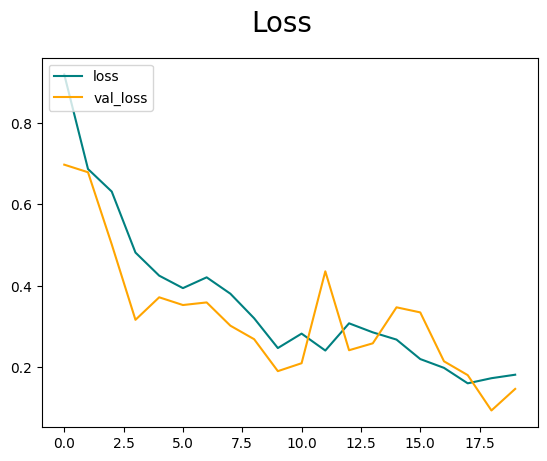

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label='val_loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

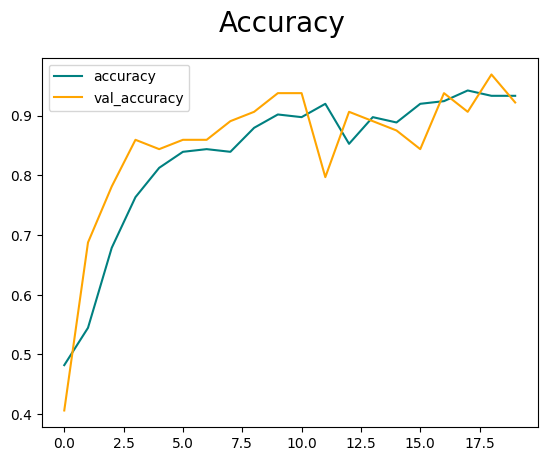

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

It seems that increasing the learning rate decreases the accuracy level down from 93% to 92%. Let's see what happens when we decrease the learning rate!

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model3 = Sequential()
model3.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3)))
model3.add(MaxPooling2D())

model3.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model3.add(MaxPooling2D())

model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1,activation='sigmoid'))
# Compile
from tensorflow.keras.optimizers import Adam
optimizer_3 = Adam(learning_rate = 0.0001) # change the learning rate
model3.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
hist = model3.fit(train, epochs=20,validation_data=validation, callbacks=[tensorboard_callback])

Because we decrease the learning rate, we increased our accuracy level from 93% to 97%! By decreasing the learning rate, the model is able to steadily learn and improve without any large fluctuations in finding the most optimal parameters. Moreover, a smaller learning rate enables the model to be more flexible in becoming more generalizable to unseen data because the model makes smaller adjustments to the weight, which encourages it to find more general patterns. 

Now that we're able to get the accuracy level to 97%, let's see if we can optimize the model by changing some aspects of the model's architecture.

We want to avoid making the model too overfitting so let's add Dropout of a rate of 25% to make a random 25% of our training dataset to be set to 0. Let's see what happens to our accuracy level.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model4 = Sequential()
model4.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3)))
model4.add(MaxPooling2D())
model4.add(Dropout(0.25))

model4.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model4.add(MaxPooling2D())
model4.add(Dropout(0.25))

model4.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model4.add(MaxPooling2D())
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1,activation='sigmoid'))

# Compile
from tensorflow.keras.optimizers import Adam
optimizer_4 = Adam(learning_rate = 0.0001) # change the learning rate
model4.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
hist = model4.fit(train, epochs=20,validation_data=validation, callbacks=[tensorboard_callback])

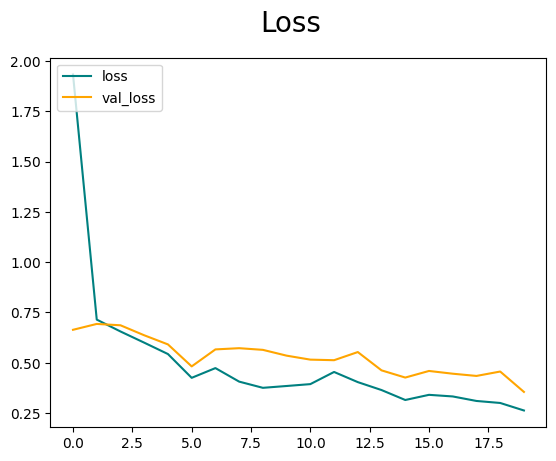

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label='val_loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

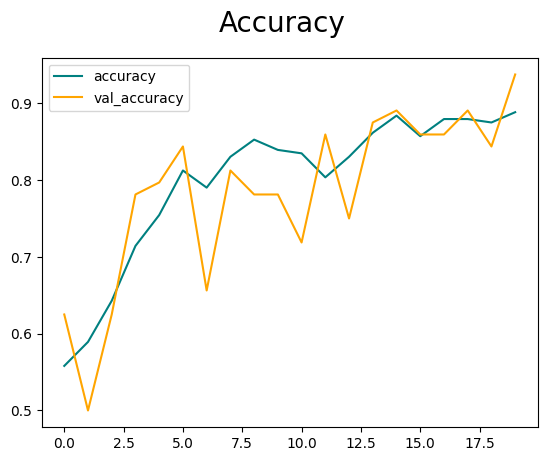

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

With our current dropout rate, we can see that the change in our model's loss is plateauing with non-significant changes while our accuracy greatly fluctuates. This is a good example of the model overfitting so let's see what happens when we increase the dropout rate. 

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model5 = Sequential()
model5.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3)))
model5.add(MaxPooling2D())
model5.add(Dropout(0.5))

model5.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model5.add(MaxPooling2D())
model5.add(Dropout(0.5))

model5.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model5.add(MaxPooling2D())
model5.add(Dropout(0.5))

model5.add(Flatten())
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.75))

model5.add(Dense(1,activation='sigmoid'))
# Compile
from tensorflow.keras.optimizers import Adam
optimizer_5 = Adam(learning_rate = 0.01) # change the learning rate
model5.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
hist = model5.fit(train, epochs=20,validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20


2024-03-12 15:07:25.300985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:25.536252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.5244 - accuracy: 0.4955

2024-03-12 15:07:28.636452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:28.854938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 497ms/step - loss: 3.5244 - accuracy: 0.4955 - val_loss: 0.7097 - val_accuracy: 0.4219
Epoch 2/20


2024-03-12 15:07:29.721108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:29.939557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.9043 - accuracy: 0.4911

2024-03-12 15:07:32.725854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:32.943091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 484ms/step - loss: 0.9043 - accuracy: 0.4911 - val_loss: 0.6856 - val_accuracy: 0.5781
Epoch 3/20


2024-03-12 15:07:33.817936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:34.033040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.5848

2024-03-12 15:07:36.858577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:37.075670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 483ms/step - loss: 0.6577 - accuracy: 0.5848 - val_loss: 0.6923 - val_accuracy: 0.6406
Epoch 4/20


2024-03-12 15:07:37.947203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:38.165181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.5893

2024-03-12 15:07:40.889884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:41.112357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 474ms/step - loss: 0.6584 - accuracy: 0.5893 - val_loss: 0.6928 - val_accuracy: 0.5625
Epoch 5/20


2024-03-12 15:07:41.978265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:42.194631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.6027

2024-03-12 15:07:45.024732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:45.244395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 482ms/step - loss: 0.6570 - accuracy: 0.6027 - val_loss: 0.6928 - val_accuracy: 0.5781
Epoch 6/20


2024-03-12 15:07:46.127383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:46.347338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.5938

2024-03-12 15:07:49.164357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:49.383161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 479ms/step - loss: 0.6689 - accuracy: 0.5938 - val_loss: 0.6931 - val_accuracy: 0.5625
Epoch 7/20


2024-03-12 15:07:50.257844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:50.482404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.6116

2024-03-12 15:07:53.600203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:53.819791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 491ms/step - loss: 0.6454 - accuracy: 0.6116 - val_loss: 0.6933 - val_accuracy: 0.3594
Epoch 8/20


2024-03-12 15:07:54.708004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:54.929579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.6027

2024-03-12 15:07:57.859533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:58.078656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 499ms/step - loss: 0.6459 - accuracy: 0.6027 - val_loss: 0.6933 - val_accuracy: 0.4688
Epoch 9/20


2024-03-12 15:07:58.961356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:07:59.181267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.6161

2024-03-12 15:08:01.997894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:02.213994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 481ms/step - loss: 0.6271 - accuracy: 0.6161 - val_loss: 0.6935 - val_accuracy: 0.4531
Epoch 10/20


2024-03-12 15:08:03.118738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:03.337829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.5938

2024-03-12 15:08:06.316421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:06.536300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 510ms/step - loss: 0.6433 - accuracy: 0.5938 - val_loss: 0.6940 - val_accuracy: 0.4219
Epoch 11/20


2024-03-12 15:08:07.417412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:07.638501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.5982

2024-03-12 15:08:10.607942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:10.829507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 508ms/step - loss: 0.6348 - accuracy: 0.5982 - val_loss: 0.6941 - val_accuracy: 0.4375
Epoch 12/20


2024-03-12 15:08:11.726759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:11.950244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.6027

2024-03-12 15:08:14.993619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:15.216057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 517ms/step - loss: 0.6058 - accuracy: 0.6027 - val_loss: 0.6951 - val_accuracy: 0.4062
Epoch 13/20


2024-03-12 15:08:16.140055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:16.365422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6069 - accuracy: 0.6027

2024-03-12 15:08:19.374641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:19.596163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 512ms/step - loss: 0.6069 - accuracy: 0.6027 - val_loss: 0.6960 - val_accuracy: 0.3906
Epoch 14/20


2024-03-12 15:08:20.497434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:20.716571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.6295

2024-03-12 15:08:23.752439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:23.978588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 509ms/step - loss: 0.6336 - accuracy: 0.6295 - val_loss: 0.6953 - val_accuracy: 0.4375
Epoch 15/20


2024-03-12 15:08:24.877921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:25.106373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.6384

2024-03-12 15:08:28.308506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:28.530334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 523ms/step - loss: 0.5936 - accuracy: 0.6384 - val_loss: 0.6988 - val_accuracy: 0.3750
Epoch 16/20


2024-03-12 15:08:29.431280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:29.656755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.6875

2024-03-12 15:08:32.918224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:33.142155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 540ms/step - loss: 0.5993 - accuracy: 0.6875 - val_loss: 0.6995 - val_accuracy: 0.3594
Epoch 17/20


2024-03-12 15:08:34.102887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:34.329704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.6964

2024-03-12 15:08:37.372576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:37.595784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 512ms/step - loss: 0.6340 - accuracy: 0.6964 - val_loss: 0.6963 - val_accuracy: 0.3906
Epoch 18/20


2024-03-12 15:08:38.496267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:38.721469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5725 - accuracy: 0.7232

2024-03-12 15:08:41.717453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:41.939768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 504ms/step - loss: 0.5725 - accuracy: 0.7232 - val_loss: 0.6862 - val_accuracy: 0.4219
Epoch 19/20


2024-03-12 15:08:42.857132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:43.078608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.8036

2024-03-12 15:08:46.008342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:46.232859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 499ms/step - loss: 0.5056 - accuracy: 0.8036 - val_loss: 0.6904 - val_accuracy: 0.2812
Epoch 20/20


2024-03-12 15:08:47.135011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:47.360532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.8036

2024-03-12 15:08:50.617658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:08:50.843492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 557ms/step - loss: 0.5001 - accuracy: 0.8036 - val_loss: 0.5773 - val_accuracy: 0.6875


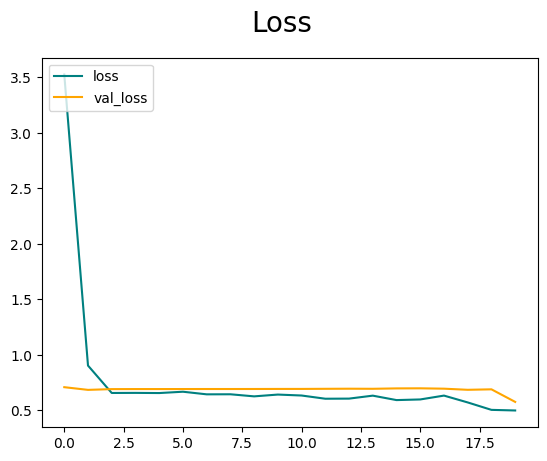

In [43]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label='val_loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

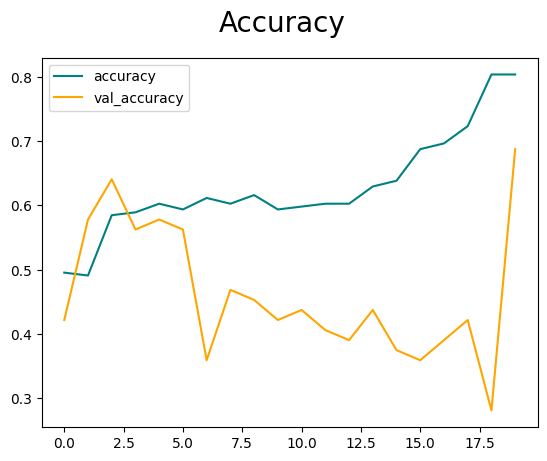

In [44]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

By increasing our dropout rate, it still shows that our model is overfitting with our loss level plateauing and our accuracy level greatly fluctuating. Let's add some L2 regularlization and see what effects it has on the loss level.

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.regularizers import l2

l2_regularizer_rate = 0.001
model5 = Sequential()
model5.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3), kernel_regularizer = l2(l2_regularizer_rate)))
model5.add(MaxPooling2D())

model5.add(Conv2D(32, (3,3), 1, activation = 'relu',kernel_regularizer = l2(l2_regularizer_rate)))
model5.add(MaxPooling2D())

model5.add(Conv2D(16, (3,3), 1, activation = 'relu',kernel_regularizer = l2(l2_regularizer_rate)))
model5.add(MaxPooling2D())

model5.add(Flatten())
model5.add(Dense(256, activation='relu',kernel_regularizer = l2(l2_regularizer_rate)))

model5.add(Dense(1,activation='sigmoid',kernel_regularizer = l2(l2_regularizer_rate)))
# Compile
from tensorflow.keras.optimizers import Adam
optimizer_5 = Adam(learning_rate = 0.01) # change the learning rate
model5.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
hist = model5.fit(train, epochs=20,validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20


2024-03-12 15:12:49.041274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:12:49.266098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.4801 - accuracy: 0.5938

2024-03-12 15:12:52.118002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:12:52.340528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 464ms/step - loss: 1.4801 - accuracy: 0.5938 - val_loss: 0.9788 - val_accuracy: 0.6875
Epoch 2/20


2024-03-12 15:12:53.257501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:12:53.480099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8361 - accuracy: 0.8080

2024-03-12 15:12:56.140118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:12:56.358069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 449ms/step - loss: 0.8361 - accuracy: 0.8080 - val_loss: 0.9210 - val_accuracy: 0.7031
Epoch 3/20


2024-03-12 15:12:57.230280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:12:57.449126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.8348

2024-03-12 15:12:59.960780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:00.181050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 440ms/step - loss: 0.6955 - accuracy: 0.8348 - val_loss: 0.7007 - val_accuracy: 0.8125
Epoch 4/20


2024-03-12 15:13:01.051130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:01.272273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.8348

2024-03-12 15:13:03.757480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:03.975871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 439ms/step - loss: 0.6644 - accuracy: 0.8348 - val_loss: 0.6581 - val_accuracy: 0.8125
Epoch 5/20


2024-03-12 15:13:04.861597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:05.087914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.8170

2024-03-12 15:13:07.877515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:08.096622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 467ms/step - loss: 0.6632 - accuracy: 0.8170 - val_loss: 0.6564 - val_accuracy: 0.7656
Epoch 6/20


2024-03-12 15:13:08.997821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:09.219034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.8616

2024-03-12 15:13:11.850253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:12.068836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 458ms/step - loss: 0.6051 - accuracy: 0.8616 - val_loss: 0.5942 - val_accuracy: 0.8438
Epoch 7/20


2024-03-12 15:13:12.952310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:13.173217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5358 - accuracy: 0.8750

2024-03-12 15:13:15.743148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:15.978303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 451ms/step - loss: 0.5358 - accuracy: 0.8750 - val_loss: 0.5241 - val_accuracy: 0.8594
Epoch 8/20


2024-03-12 15:13:16.907182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:17.127217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.8616

2024-03-12 15:13:19.912020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:20.134488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 479ms/step - loss: 0.4802 - accuracy: 0.8616 - val_loss: 0.5738 - val_accuracy: 0.8750
Epoch 9/20


2024-03-12 15:13:21.016986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:21.240154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.9062

2024-03-12 15:13:23.870273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:24.091379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 448ms/step - loss: 0.4571 - accuracy: 0.9062 - val_loss: 0.4027 - val_accuracy: 0.9531
Epoch 10/20


2024-03-12 15:13:24.969140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:25.190289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.9286

2024-03-12 15:13:27.695235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:27.915914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 442ms/step - loss: 0.3982 - accuracy: 0.9286 - val_loss: 0.4537 - val_accuracy: 0.8906
Epoch 11/20


2024-03-12 15:13:28.793599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:29.017275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.9196

2024-03-12 15:13:31.586200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:31.805590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 451ms/step - loss: 0.3805 - accuracy: 0.9196 - val_loss: 0.3934 - val_accuracy: 0.9375
Epoch 12/20


2024-03-12 15:13:32.692166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:32.913747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.9152

2024-03-12 15:13:35.458533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:35.679326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 447ms/step - loss: 0.3840 - accuracy: 0.9152 - val_loss: 0.4251 - val_accuracy: 0.9219
Epoch 13/20


2024-03-12 15:13:36.548962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:36.769365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.9286

2024-03-12 15:13:39.282981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:39.503345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 440ms/step - loss: 0.3672 - accuracy: 0.9286 - val_loss: 0.3856 - val_accuracy: 0.8906
Epoch 14/20


2024-03-12 15:13:40.373650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:40.591968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.9375

2024-03-12 15:13:43.187679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:43.410421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 456ms/step - loss: 0.3519 - accuracy: 0.9375 - val_loss: 0.3364 - val_accuracy: 0.9531
Epoch 15/20


2024-03-12 15:13:44.324063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:44.545087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.9509

2024-03-12 15:13:47.210971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:47.429945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 451ms/step - loss: 0.3066 - accuracy: 0.9509 - val_loss: 0.2639 - val_accuracy: 0.9844
Epoch 16/20


2024-03-12 15:13:48.311794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:48.533309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.9464

2024-03-12 15:13:51.091937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:51.311891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 453ms/step - loss: 0.3150 - accuracy: 0.9464 - val_loss: 0.3275 - val_accuracy: 0.9062
Epoch 17/20


2024-03-12 15:13:52.223171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:52.441956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.9509

2024-03-12 15:13:54.981616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:55.201889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 447ms/step - loss: 0.3000 - accuracy: 0.9509 - val_loss: 0.2826 - val_accuracy: 0.9219
Epoch 18/20


2024-03-12 15:13:56.078506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:56.303623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.9420

2024-03-12 15:13:58.879806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:13:59.100349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 449ms/step - loss: 0.3123 - accuracy: 0.9420 - val_loss: 0.3771 - val_accuracy: 0.9375
Epoch 19/20


2024-03-12 15:14:00.008579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:14:00.230306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.9420

2024-03-12 15:14:02.808632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:14:03.030869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 448ms/step - loss: 0.2919 - accuracy: 0.9420 - val_loss: 0.2762 - val_accuracy: 0.9688
Epoch 20/20


2024-03-12 15:14:03.913534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:14:04.132318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.9420

2024-03-12 15:14:06.672162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:14:06.893940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 448ms/step - loss: 0.3108 - accuracy: 0.9420 - val_loss: 0.2731 - val_accuracy: 0.9375


With our L2 regularizer, our accuracy got to 93%. What happens when we increase the L2 regularizer rate?

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.regularizers import l2

l2_regularizer_rate = 0.01
model7 = Sequential()
model7.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256,3), kernel_regularizer = l2(l2_regularizer_rate)))
model7.add(MaxPooling2D())

model7.add(Conv2D(32, (3,3), 1, activation = 'relu',kernel_regularizer = l2(l2_regularizer_rate)))
model7.add(MaxPooling2D())

model7.add(Conv2D(16, (3,3), 1, activation = 'relu',kernel_regularizer = l2(l2_regularizer_rate)))
model7.add(MaxPooling2D())

model7.add(Flatten())
model7.add(Dense(256, activation='relu',kernel_regularizer = l2(l2_regularizer_rate)))

model7.add(Dense(1,activation='sigmoid',kernel_regularizer = l2(l2_regularizer_rate)))
# Compile
from tensorflow.keras.optimizers import Adam
optimizer_7 = Adam(learning_rate = 0.01) # change the learning rate
model7.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
hist = model7.fit(train, epochs=20,validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20


2024-03-12 15:15:49.833677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:15:50.062027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 5.1388 - accuracy: 0.5179

2024-03-12 15:15:52.787988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:15:53.008205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 475ms/step - loss: 5.1388 - accuracy: 0.5179 - val_loss: 3.3595 - val_accuracy: 0.5469
Epoch 2/20


2024-03-12 15:15:53.992207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:15:54.278669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.7024 - accuracy: 0.6295

2024-03-12 15:15:57.092134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:15:57.309412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 468ms/step - loss: 2.7024 - accuracy: 0.6295 - val_loss: 2.0016 - val_accuracy: 0.7969
Epoch 3/20


2024-03-12 15:15:58.181041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:15:58.407431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.8117 - accuracy: 0.7545

2024-03-12 15:16:00.956698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:01.176471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 444ms/step - loss: 1.8117 - accuracy: 0.7545 - val_loss: 1.5691 - val_accuracy: 0.8438
Epoch 4/20


2024-03-12 15:16:02.037801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:02.257157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.4939 - accuracy: 0.7991

2024-03-12 15:16:04.702722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:04.921583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 436ms/step - loss: 1.4939 - accuracy: 0.7991 - val_loss: 1.5341 - val_accuracy: 0.7812
Epoch 5/20


2024-03-12 15:16:05.821488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:06.044239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.3618 - accuracy: 0.8036

2024-03-12 15:16:08.600421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:08.821332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 446ms/step - loss: 1.3618 - accuracy: 0.8036 - val_loss: 1.2381 - val_accuracy: 0.8438
Epoch 6/20


2024-03-12 15:16:09.676440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:09.897572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.2135 - accuracy: 0.8214

2024-03-12 15:16:12.467616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:12.688377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 444ms/step - loss: 1.2135 - accuracy: 0.8214 - val_loss: 0.9660 - val_accuracy: 0.9062
Epoch 7/20


2024-03-12 15:16:13.573322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:13.792146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0616 - accuracy: 0.8393

2024-03-12 15:16:16.258027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:16.478530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 436ms/step - loss: 1.0616 - accuracy: 0.8393 - val_loss: 1.0316 - val_accuracy: 0.8125
Epoch 8/20


2024-03-12 15:16:17.398116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:17.620477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.9848 - accuracy: 0.8438

2024-03-12 15:16:20.230502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:20.450982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 441ms/step - loss: 0.9848 - accuracy: 0.8438 - val_loss: 0.8764 - val_accuracy: 0.9062
Epoch 9/20


2024-03-12 15:16:21.322602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:21.551751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8697 - accuracy: 0.8750

2024-03-12 15:16:24.856975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:25.078956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 555ms/step - loss: 0.8697 - accuracy: 0.8750 - val_loss: 0.8583 - val_accuracy: 0.8750
Epoch 10/20


2024-03-12 15:16:26.106948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:26.329042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8541 - accuracy: 0.8482

2024-03-12 15:16:28.954130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:29.175076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 444ms/step - loss: 0.8541 - accuracy: 0.8482 - val_loss: 0.8921 - val_accuracy: 0.7969
Epoch 11/20


2024-03-12 15:16:30.041484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:30.259381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.8571

2024-03-12 15:16:32.710910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:32.931442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 432ms/step - loss: 0.7977 - accuracy: 0.8571 - val_loss: 0.8036 - val_accuracy: 0.8281
Epoch 12/20


2024-03-12 15:16:33.796482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:34.018992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.8929

2024-03-12 15:16:36.473578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:36.692456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 432ms/step - loss: 0.7028 - accuracy: 0.8929 - val_loss: 0.7060 - val_accuracy: 0.8906
Epoch 13/20


2024-03-12 15:16:37.566432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:37.786133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.7604 - accuracy: 0.8661

2024-03-12 15:16:40.307453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:40.523222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 446ms/step - loss: 0.7604 - accuracy: 0.8661 - val_loss: 0.7748 - val_accuracy: 0.8438
Epoch 14/20


2024-03-12 15:16:41.413655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:41.663632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.8705

2024-03-12 15:16:44.579945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:44.797997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 467ms/step - loss: 0.6962 - accuracy: 0.8705 - val_loss: 0.5518 - val_accuracy: 0.9375
Epoch 15/20


2024-03-12 15:16:45.716493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:45.938903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.8750

2024-03-12 15:16:48.945183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:49.170199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 493ms/step - loss: 0.6853 - accuracy: 0.8750 - val_loss: 0.7536 - val_accuracy: 0.8594
Epoch 16/20


2024-03-12 15:16:50.046347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:50.271513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6373 - accuracy: 0.8884

2024-03-12 15:16:52.723630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:52.943833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 437ms/step - loss: 0.6373 - accuracy: 0.8884 - val_loss: 0.6527 - val_accuracy: 0.8906
Epoch 17/20


2024-03-12 15:16:53.833900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:54.053859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.8839

2024-03-12 15:16:56.528856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:56.752980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 437ms/step - loss: 0.6271 - accuracy: 0.8839 - val_loss: 0.6502 - val_accuracy: 0.8594
Epoch 18/20


2024-03-12 15:16:57.643692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:16:57.863226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.5601 - accuracy: 0.9018

2024-03-12 15:17:00.411354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:17:00.632656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 449ms/step - loss: 0.5601 - accuracy: 0.9018 - val_loss: 0.6838 - val_accuracy: 0.8594
Epoch 19/20


2024-03-12 15:17:01.494015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:17:01.715072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.6416 - accuracy: 0.8527

2024-03-12 15:17:04.243537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:17:04.470811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 444ms/step - loss: 0.6416 - accuracy: 0.8527 - val_loss: 0.5418 - val_accuracy: 0.9219
Epoch 20/20


2024-03-12 15:17:05.340087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:17:05.560246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.8304

2024-03-12 15:17:08.030228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-12 15:17:08.250663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 437ms/step - loss: 0.7354 - accuracy: 0.8304 - val_loss: 0.8367 - val_accuracy: 0.7344


Because we increase our L2 rate, the model becomes stricter in adding more weight on the parameters, which could lead to underfitting as shown by our low 73% validation rate. To find the most optimal L2 rate, let's do a grid search.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2

def build_model(dropout_rate=0.5, l2_rate=0.01):
    model = Sequential([
        Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(l2_rate)),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(32, (3,3), 1, activation='relu'),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(16,(3,3), 1, activation='relu'),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [22]:
# Hyperparameter grid
param_grid = {
    'dropout_rate': [0.25, 0.5, 0.75],
    'l2_rate': [0.001, 0.01, 0.1]
}

In [23]:
best_score = 0
best_params = None

for dropout_rate in param_grid['dropout_rate']:
    for l2_rate in param_grid['l2_rate']:
        # Build and compile the model with the current set of hyperparameters
        model = build_model(dropout_rate=dropout_rate, l2_rate=l2_rate)
        
        # Fit the model
        history = model.fit(train, validation_data= validation, epochs=10)
        
        # Evaluate the model (e.g., using validation accuracy)
        val_accuracy = max(history.history['val_accuracy'])
        
        # Update best score and parameters if current model is better
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = {'dropout_rate': dropout_rate, 'l2_rate': l2_rate}

Epoch 1/10


2024-03-13 12:30:15.706105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:15.706124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.1073 - accuracy: 0.5848

2024-03-13 12:30:19.195935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:19.197249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 567ms/step - loss: 2.1073 - accuracy: 0.5848 - val_loss: 1.1220 - val_accuracy: 0.5938
Epoch 2/10


2024-03-13 12:30:20.371970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:20.372701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.2129 - accuracy: 0.5938

2024-03-13 12:30:23.611449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:23.611882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 551ms/step - loss: 1.2129 - accuracy: 0.5938 - val_loss: 1.0926 - val_accuracy: 0.4688
Epoch 3/10


2024-03-13 12:30:24.809580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:24.809839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0726 - accuracy: 0.5580

2024-03-13 12:30:28.039540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:28.040198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 536ms/step - loss: 1.0726 - accuracy: 0.5580 - val_loss: 1.0572 - val_accuracy: 0.4062
Epoch 4/10


2024-03-13 12:30:29.221345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:29.222076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0403 - accuracy: 0.5804

2024-03-13 12:30:32.644681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:32.645900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 573ms/step - loss: 1.0403 - accuracy: 0.5804 - val_loss: 1.0262 - val_accuracy: 0.5469
Epoch 5/10


2024-03-13 12:30:33.836991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:33.837487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0081 - accuracy: 0.5848

2024-03-13 12:30:36.948955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:36.949372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 527ms/step - loss: 1.0081 - accuracy: 0.5848 - val_loss: 0.9968 - val_accuracy: 0.6094
Epoch 6/10


2024-03-13 12:30:38.119214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:38.119601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.9643 - accuracy: 0.5804

2024-03-13 12:30:41.095624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:41.096617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 505ms/step - loss: 0.9643 - accuracy: 0.5804 - val_loss: 0.9577 - val_accuracy: 0.6250
Epoch 7/10


2024-03-13 12:30:42.270881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:42.270896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.9269 - accuracy: 0.5804

2024-03-13 12:30:45.355103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:45.355327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 521ms/step - loss: 0.9269 - accuracy: 0.5804 - val_loss: 0.9316 - val_accuracy: 0.5312
Epoch 8/10


2024-03-13 12:30:46.496742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:46.497099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.5759

2024-03-13 12:30:49.510509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:49.511595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 519ms/step - loss: 0.8996 - accuracy: 0.5759 - val_loss: 0.8714 - val_accuracy: 0.5156
Epoch 9/10


2024-03-13 12:30:50.667145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:50.667474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8285 - accuracy: 0.6071

2024-03-13 12:30:53.621276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:53.621693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 491ms/step - loss: 0.8285 - accuracy: 0.6071 - val_loss: 0.7977 - val_accuracy: 0.6562
Epoch 10/10


2024-03-13 12:30:54.749135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:54.749426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8048 - accuracy: 0.6384

2024-03-13 12:30:57.987123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:30:57.987245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 516ms/step - loss: 0.8048 - accuracy: 0.6384 - val_loss: 0.7995 - val_accuracy: 0.8750
Epoch 1/10


2024-03-13 12:31:00.063538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:00.064229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 6.7701 - accuracy: 0.5938

2024-03-13 12:31:02.950160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:02.950374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 491ms/step - loss: 6.7701 - accuracy: 0.5938 - val_loss: 4.1867 - val_accuracy: 0.3750
Epoch 2/10


2024-03-13 12:31:04.068309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:04.068433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.7456 - accuracy: 0.4911

2024-03-13 12:31:06.871297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:06.872051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 480ms/step - loss: 3.7456 - accuracy: 0.4911 - val_loss: 3.1769 - val_accuracy: 0.6094
Epoch 3/10


2024-03-13 12:31:08.007909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:08.010093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.8980 - accuracy: 0.6071

2024-03-13 12:31:10.818123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:10.819236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 483ms/step - loss: 2.8980 - accuracy: 0.6071 - val_loss: 2.6598 - val_accuracy: 0.6875
Epoch 4/10


2024-03-13 12:31:11.983767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:11.983915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.4787 - accuracy: 0.5848

2024-03-13 12:31:14.778322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:14.778437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 481ms/step - loss: 2.4787 - accuracy: 0.5848 - val_loss: 2.3372 - val_accuracy: 0.4375
Epoch 5/10


2024-03-13 12:31:15.912714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:15.913511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.1556 - accuracy: 0.6429

2024-03-13 12:31:18.714843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:18.715989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 483ms/step - loss: 2.1556 - accuracy: 0.6429 - val_loss: 2.0788 - val_accuracy: 0.6562
Epoch 6/10


2024-03-13 12:31:19.841313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:19.842129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.9418 - accuracy: 0.5848

2024-03-13 12:31:22.614321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:22.614660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 475ms/step - loss: 1.9418 - accuracy: 0.5848 - val_loss: 1.8771 - val_accuracy: 0.4531
Epoch 7/10


2024-03-13 12:31:23.735366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:23.736366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.7373 - accuracy: 0.6205

2024-03-13 12:31:26.525337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:26.526363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 478ms/step - loss: 1.7373 - accuracy: 0.6205 - val_loss: 1.7070 - val_accuracy: 0.6875
Epoch 8/10


2024-03-13 12:31:27.646565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:27.646935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.6018 - accuracy: 0.6161

2024-03-13 12:31:30.410203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:30.410545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 477ms/step - loss: 1.6018 - accuracy: 0.6161 - val_loss: 1.5883 - val_accuracy: 0.7031
Epoch 9/10


2024-03-13 12:31:31.539568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:31.540080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.4860 - accuracy: 0.6518

2024-03-13 12:31:34.316646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:34.316970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 475ms/step - loss: 1.4860 - accuracy: 0.6518 - val_loss: 1.4982 - val_accuracy: 0.4219
Epoch 10/10


2024-03-13 12:31:35.445198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:35.445679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.4123 - accuracy: 0.7455

2024-03-13 12:31:38.226658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:38.226832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 477ms/step - loss: 1.4123 - accuracy: 0.7455 - val_loss: 1.4189 - val_accuracy: 0.3438
Epoch 1/10


2024-03-13 12:31:39.651447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:39.651800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 36.3658 - accuracy: 0.5402

2024-03-13 12:31:42.678143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:42.678706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 499ms/step - loss: 36.3658 - accuracy: 0.5402 - val_loss: 19.8051 - val_accuracy: 0.5938
Epoch 2/10


2024-03-13 12:31:43.805112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:43.805220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 13.0171 - accuracy: 0.5938

2024-03-13 12:31:46.617218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:46.617977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 483ms/step - loss: 13.0171 - accuracy: 0.5938 - val_loss: 6.7189 - val_accuracy: 0.4219
Epoch 3/10


2024-03-13 12:31:47.738905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:47.739606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 4.8085 - accuracy: 0.7679

2024-03-13 12:31:50.521388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:50.521475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 474ms/step - loss: 4.8085 - accuracy: 0.7679 - val_loss: 3.3145 - val_accuracy: 0.7344
Epoch 4/10


2024-03-13 12:31:51.637040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:51.638211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.8997 - accuracy: 0.6652

2024-03-13 12:31:54.445416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:54.445811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 484ms/step - loss: 2.8997 - accuracy: 0.6652 - val_loss: 2.5183 - val_accuracy: 0.7344
Epoch 5/10


2024-03-13 12:31:55.707969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:55.708015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.2755 - accuracy: 0.6830

2024-03-13 12:31:58.517063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:58.517890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 482ms/step - loss: 2.2755 - accuracy: 0.6830 - val_loss: 1.9077 - val_accuracy: 0.7812
Epoch 6/10


2024-03-13 12:31:59.691478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:31:59.691935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.6967 - accuracy: 0.6786

2024-03-13 12:32:02.518728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:02.519074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 485ms/step - loss: 1.6967 - accuracy: 0.6786 - val_loss: 1.4755 - val_accuracy: 0.6719
Epoch 7/10


2024-03-13 12:32:03.649520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:03.650447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.2740 - accuracy: 0.7902

2024-03-13 12:32:06.464500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:06.465701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 481ms/step - loss: 1.2740 - accuracy: 0.7902 - val_loss: 1.1773 - val_accuracy: 0.8281
Epoch 8/10


2024-03-13 12:32:07.587177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:07.588112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0107 - accuracy: 0.7857

2024-03-13 12:32:10.387262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:10.388258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 479ms/step - loss: 1.0107 - accuracy: 0.7857 - val_loss: 0.9759 - val_accuracy: 0.7969
Epoch 9/10


2024-03-13 12:32:11.505516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:11.506204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8769 - accuracy: 0.8438

2024-03-13 12:32:14.322484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:14.322922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 485ms/step - loss: 0.8769 - accuracy: 0.8438 - val_loss: 0.8750 - val_accuracy: 0.8438
Epoch 10/10


2024-03-13 12:32:15.451374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:15.451864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.8558 - accuracy: 0.8036

2024-03-13 12:32:18.232681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:18.233313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 478ms/step - loss: 0.8558 - accuracy: 0.8036 - val_loss: 0.8955 - val_accuracy: 0.8281
Epoch 1/10


2024-03-13 12:32:19.680405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:19.680689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.4873 - accuracy: 0.5223

2024-03-13 12:32:22.577701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:22.578425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 496ms/step - loss: 2.4873 - accuracy: 0.5223 - val_loss: 1.1713 - val_accuracy: 0.5781
Epoch 2/10


2024-03-13 12:32:23.728484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:23.728621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.3986 - accuracy: 0.5446

2024-03-13 12:32:26.602447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:26.602935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 488ms/step - loss: 1.3986 - accuracy: 0.5446 - val_loss: 1.1846 - val_accuracy: 0.4219
Epoch 3/10


2024-03-13 12:32:27.744609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:27.745570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.1857 - accuracy: 0.5134

2024-03-13 12:32:30.579431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:30.579803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 482ms/step - loss: 1.1857 - accuracy: 0.5134 - val_loss: 1.1707 - val_accuracy: 0.4688
Epoch 4/10


2024-03-13 12:32:31.705699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:31.706263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.1638 - accuracy: 0.5134

2024-03-13 12:32:34.556672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:34.556950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 483ms/step - loss: 1.1638 - accuracy: 0.5134 - val_loss: 1.1561 - val_accuracy: 0.5312
Epoch 5/10


2024-03-13 12:32:35.667087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:35.667481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.1277 - accuracy: 0.6384

2024-03-13 12:32:38.502160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:38.502572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 484ms/step - loss: 1.1277 - accuracy: 0.6384 - val_loss: 1.1389 - val_accuracy: 0.5000
Epoch 6/10


2024-03-13 12:32:39.620427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:39.620538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0942 - accuracy: 0.6161

2024-03-13 12:32:42.484647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:42.485454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 489ms/step - loss: 1.0942 - accuracy: 0.6161 - val_loss: 1.1205 - val_accuracy: 0.5156
Epoch 7/10


2024-03-13 12:32:43.603001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:43.603441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0760 - accuracy: 0.5848

2024-03-13 12:32:46.433875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:46.434271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 485ms/step - loss: 1.0760 - accuracy: 0.5848 - val_loss: 1.0976 - val_accuracy: 0.5781
Epoch 8/10


2024-03-13 12:32:47.563604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:47.564127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0424 - accuracy: 0.5893

2024-03-13 12:32:50.413319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:50.413563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 489ms/step - loss: 1.0424 - accuracy: 0.5893 - val_loss: 1.0809 - val_accuracy: 0.6406
Epoch 9/10


2024-03-13 12:32:51.556470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:51.557348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0119 - accuracy: 0.6295

2024-03-13 12:32:54.383373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:54.384566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 484ms/step - loss: 1.0119 - accuracy: 0.6295 - val_loss: 1.0472 - val_accuracy: 0.7656
Epoch 10/10


2024-03-13 12:32:55.627258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:55.628907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 0.9129 - accuracy: 0.7545

2024-03-13 12:32:58.580762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:32:58.581391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 502ms/step - loss: 0.9129 - accuracy: 0.7545 - val_loss: 0.9261 - val_accuracy: 0.8125
Epoch 1/10


2024-03-13 12:33:00.009436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:00.011028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 6.8023 - accuracy: 0.5357

2024-03-13 12:33:02.936205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:02.937526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 499ms/step - loss: 6.8023 - accuracy: 0.5357 - val_loss: 4.8611 - val_accuracy: 0.5312
Epoch 2/10


2024-03-13 12:33:04.058378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:04.059514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 4.6565 - accuracy: 0.5759

2024-03-13 12:33:06.927671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:06.928602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 488ms/step - loss: 4.6565 - accuracy: 0.5759 - val_loss: 4.1392 - val_accuracy: 0.4844
Epoch 3/10


2024-03-13 12:33:08.058687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:08.059011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.8734 - accuracy: 0.5893

2024-03-13 12:33:10.935080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:10.935980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 492ms/step - loss: 3.8734 - accuracy: 0.5893 - val_loss: 3.5867 - val_accuracy: 0.3906
Epoch 4/10


2024-03-13 12:33:12.059966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:12.061313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.3806 - accuracy: 0.5446

2024-03-13 12:33:14.906137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:14.906289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 484ms/step - loss: 3.3806 - accuracy: 0.5446 - val_loss: 3.1412 - val_accuracy: 0.3438
Epoch 5/10


2024-03-13 12:33:16.030235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:16.030371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.9606 - accuracy: 0.6161

2024-03-13 12:33:18.888273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:18.888410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 491ms/step - loss: 2.9606 - accuracy: 0.6161 - val_loss: 2.7623 - val_accuracy: 0.3750
Epoch 6/10


2024-03-13 12:33:20.023288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:20.023523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.6046 - accuracy: 0.6205

2024-03-13 12:33:22.874509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:22.874618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 484ms/step - loss: 2.6046 - accuracy: 0.6205 - val_loss: 2.4438 - val_accuracy: 0.6406
Epoch 7/10


2024-03-13 12:33:23.999820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:24.000567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.2837 - accuracy: 0.5982

2024-03-13 12:33:26.846832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:26.847506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 488ms/step - loss: 2.2837 - accuracy: 0.5982 - val_loss: 2.1597 - val_accuracy: 0.5938
Epoch 8/10


2024-03-13 12:33:27.970127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:27.970569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.0355 - accuracy: 0.6295

2024-03-13 12:33:30.813565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:30.813987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 486ms/step - loss: 2.0355 - accuracy: 0.6295 - val_loss: 1.9677 - val_accuracy: 0.6719
Epoch 9/10


2024-03-13 12:33:31.945484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:31.945797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.8457 - accuracy: 0.6027

2024-03-13 12:33:34.788715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:34.789066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 486ms/step - loss: 1.8457 - accuracy: 0.6027 - val_loss: 1.7979 - val_accuracy: 0.5156
Epoch 10/10


2024-03-13 12:33:35.918691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:35.919251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.6624 - accuracy: 0.6161

2024-03-13 12:33:38.758557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:38.758737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 482ms/step - loss: 1.6624 - accuracy: 0.6161 - val_loss: 1.5846 - val_accuracy: 0.7344
Epoch 1/10


2024-03-13 12:33:40.184433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:40.184884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 41.2221 - accuracy: 0.5670

2024-03-13 12:33:43.083076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:43.083268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 495ms/step - loss: 41.2221 - accuracy: 0.5670 - val_loss: 26.3078 - val_accuracy: 0.3594
Epoch 2/10


2024-03-13 12:33:44.219092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:44.219209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 19.7004 - accuracy: 0.4643

2024-03-13 12:33:47.112683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:47.112911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 489ms/step - loss: 19.7004 - accuracy: 0.4643 - val_loss: 12.7753 - val_accuracy: 0.4531
Epoch 3/10


2024-03-13 12:33:48.241198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:48.242485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 9.9583 - accuracy: 0.5714 

2024-03-13 12:33:51.138681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:51.139131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 496ms/step - loss: 9.9583 - accuracy: 0.5714 - val_loss: 7.2352 - val_accuracy: 0.5938
Epoch 4/10


2024-03-13 12:33:52.266220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:52.266945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 6.0908 - accuracy: 0.5804

2024-03-13 12:33:55.177910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:55.178976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 517ms/step - loss: 6.0908 - accuracy: 0.5804 - val_loss: 4.9024 - val_accuracy: 0.6250
Epoch 5/10


2024-03-13 12:33:56.428051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:56.428413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 4.2109 - accuracy: 0.6071

2024-03-13 12:33:59.336714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:33:59.336808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 493ms/step - loss: 4.2109 - accuracy: 0.6071 - val_loss: 3.4567 - val_accuracy: 0.5781
Epoch 6/10


2024-03-13 12:34:00.463331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:00.464035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.9674 - accuracy: 0.5893

2024-03-13 12:34:03.339913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:03.340293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 489ms/step - loss: 2.9674 - accuracy: 0.5893 - val_loss: 2.4599 - val_accuracy: 0.7656
Epoch 7/10


2024-03-13 12:34:04.470566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:04.470965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.1510 - accuracy: 0.5982

2024-03-13 12:34:07.335732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:07.336998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 488ms/step - loss: 2.1510 - accuracy: 0.5982 - val_loss: 1.8928 - val_accuracy: 0.6250
Epoch 8/10


2024-03-13 12:34:08.465499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:08.465514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.7005 - accuracy: 0.5938

2024-03-13 12:34:11.354800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:11.355493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 493ms/step - loss: 1.7005 - accuracy: 0.5938 - val_loss: 1.5928 - val_accuracy: 0.6094
Epoch 9/10


2024-03-13 12:34:12.491461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:12.491798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.4467 - accuracy: 0.6205

2024-03-13 12:34:15.347334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:15.347900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 495ms/step - loss: 1.4467 - accuracy: 0.6205 - val_loss: 1.4268 - val_accuracy: 0.5938
Epoch 10/10


2024-03-13 12:34:16.530929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:16.531129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.3068 - accuracy: 0.6607

2024-03-13 12:34:19.396939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:19.398365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 488ms/step - loss: 1.3068 - accuracy: 0.6607 - val_loss: 1.3337 - val_accuracy: 0.4062
Epoch 1/10


2024-03-13 12:34:20.824010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:20.824557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 4.9917 - accuracy: 0.5670

2024-03-13 12:34:23.752122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:23.752425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 501ms/step - loss: 4.9917 - accuracy: 0.5670 - val_loss: 1.1100 - val_accuracy: 0.4844
Epoch 2/10


2024-03-13 12:34:24.895510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:24.896098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 2.2730 - accuracy: 0.5312

2024-03-13 12:34:27.715815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:27.715861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 487ms/step - loss: 2.2730 - accuracy: 0.5312 - val_loss: 1.1005 - val_accuracy: 0.3594
Epoch 3/10


2024-03-13 12:34:28.901197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:28.901539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.3615 - accuracy: 0.5045

2024-03-13 12:34:31.786959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:31.788331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 494ms/step - loss: 1.3615 - accuracy: 0.5045 - val_loss: 1.1076 - val_accuracy: 0.3438
Epoch 4/10


2024-03-13 12:34:32.935257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:32.935386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.1693 - accuracy: 0.5000

2024-03-13 12:34:35.820800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:35.821042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 493ms/step - loss: 1.1693 - accuracy: 0.5000 - val_loss: 1.1124 - val_accuracy: 0.4531
Epoch 5/10


2024-03-13 12:34:36.949613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:36.950133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.1275 - accuracy: 0.5402

2024-03-13 12:34:39.890689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:39.891419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 493ms/step - loss: 1.1275 - accuracy: 0.5402 - val_loss: 1.1127 - val_accuracy: 0.3594
Epoch 6/10


2024-03-13 12:34:41.020340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:41.020384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0978 - accuracy: 0.5536

2024-03-13 12:34:43.882895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:43.883035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 488ms/step - loss: 1.0978 - accuracy: 0.5536 - val_loss: 1.1095 - val_accuracy: 0.5312
Epoch 7/10


2024-03-13 12:34:45.016294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:45.016541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0795 - accuracy: 0.6116

2024-03-13 12:34:47.814285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:47.814887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 475ms/step - loss: 1.0795 - accuracy: 0.6116 - val_loss: 1.1050 - val_accuracy: 0.6250
Epoch 8/10


2024-03-13 12:34:48.936692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:48.937676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0848 - accuracy: 0.5580

2024-03-13 12:34:51.764832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:51.765850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 482ms/step - loss: 1.0848 - accuracy: 0.5580 - val_loss: 1.1011 - val_accuracy: 0.5469
Epoch 9/10


2024-03-13 12:34:52.893232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:52.893679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0948 - accuracy: 0.5848

2024-03-13 12:34:55.852913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:55.853577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 501ms/step - loss: 1.0948 - accuracy: 0.5848 - val_loss: 1.0961 - val_accuracy: 0.6094
Epoch 10/10


2024-03-13 12:34:56.994375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:56.994485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 1.0743 - accuracy: 0.5848

2024-03-13 12:34:59.847163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:34:59.848055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 491ms/step - loss: 1.0743 - accuracy: 0.5848 - val_loss: 1.0916 - val_accuracy: 0.5938
Epoch 1/10


2024-03-13 12:35:01.313867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:01.314339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 12.1888 - accuracy: 0.5089

2024-03-13 12:35:04.255813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:04.256262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 496ms/step - loss: 12.1888 - accuracy: 0.5089 - val_loss: 4.5538 - val_accuracy: 0.4062
Epoch 2/10


2024-03-13 12:35:05.403554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:05.404861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 6.2229 - accuracy: 0.5491

2024-03-13 12:35:08.231424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:08.231569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 483ms/step - loss: 6.2229 - accuracy: 0.5491 - val_loss: 4.2813 - val_accuracy: 0.5938
Epoch 3/10


2024-03-13 12:35:09.361360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:09.361432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 4.6977 - accuracy: 0.5446

2024-03-13 12:35:12.193806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:12.194702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 485ms/step - loss: 4.6977 - accuracy: 0.5446 - val_loss: 4.2194 - val_accuracy: 0.3906
Epoch 4/10


2024-03-13 12:35:13.328884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:13.329682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 4.2364 - accuracy: 0.5045

2024-03-13 12:35:16.131103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:16.131753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 480ms/step - loss: 4.2364 - accuracy: 0.5045 - val_loss: 4.1455 - val_accuracy: 0.4062
Epoch 5/10


2024-03-13 12:35:17.257730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:17.257932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 4.1079 - accuracy: 0.5089

2024-03-13 12:35:20.076917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:20.077333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 483ms/step - loss: 4.1079 - accuracy: 0.5089 - val_loss: 4.0259 - val_accuracy: 0.4219
Epoch 6/10


2024-03-13 12:35:21.209672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:21.209882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.9667 - accuracy: 0.5179

2024-03-13 12:35:24.017938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:24.018864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 483ms/step - loss: 3.9667 - accuracy: 0.5179 - val_loss: 3.8874 - val_accuracy: 0.3594
Epoch 7/10


2024-03-13 12:35:25.147605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:25.148053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.8127 - accuracy: 0.5714

2024-03-13 12:35:27.990872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:27.991554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 488ms/step - loss: 3.8127 - accuracy: 0.5714 - val_loss: 3.7498 - val_accuracy: 0.3438
Epoch 8/10


2024-03-13 12:35:29.122537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:29.122856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.6738 - accuracy: 0.5804

2024-03-13 12:35:32.098255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:32.099182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 508ms/step - loss: 3.6738 - accuracy: 0.5804 - val_loss: 3.6167 - val_accuracy: 0.5469
Epoch 9/10


2024-03-13 12:35:33.231190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:33.231584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.5460 - accuracy: 0.5446

2024-03-13 12:35:36.069590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:36.069843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 494ms/step - loss: 3.5460 - accuracy: 0.5446 - val_loss: 3.4872 - val_accuracy: 0.6562
Epoch 10/10


2024-03-13 12:35:37.283504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:37.283917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 3.4028 - accuracy: 0.5714

2024-03-13 12:35:40.578305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:40.579731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 530ms/step - loss: 3.4028 - accuracy: 0.5714 - val_loss: 3.3638 - val_accuracy: 0.5781
Epoch 1/10


2024-03-13 12:35:42.056327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:42.056552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 45.1833 - accuracy: 0.5045

2024-03-13 12:35:45.213038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:45.214336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 520ms/step - loss: 45.1833 - accuracy: 0.5045 - val_loss: 33.7100 - val_accuracy: 0.5000
Epoch 2/10


2024-03-13 12:35:46.378809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:46.380049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 31.6034 - accuracy: 0.4955

2024-03-13 12:35:50.041732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:50.042281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 5s 630ms/step - loss: 31.6034 - accuracy: 0.4955 - val_loss: 26.5510 - val_accuracy: 0.3906
Epoch 3/10


2024-03-13 12:35:51.249251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:51.249667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 24.9083 - accuracy: 0.5580

2024-03-13 12:35:54.483759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:54.484747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 557ms/step - loss: 24.9083 - accuracy: 0.5580 - val_loss: 22.4338 - val_accuracy: 0.4062
Epoch 4/10


2024-03-13 12:35:55.808203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:55.809562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 20.9505 - accuracy: 0.5759

2024-03-13 12:35:58.972649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:35:58.973103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 531ms/step - loss: 20.9505 - accuracy: 0.5759 - val_loss: 19.1003 - val_accuracy: 0.4062
Epoch 5/10


2024-03-13 12:36:00.151525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:00.152525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 17.7220 - accuracy: 0.5089

2024-03-13 12:36:04.776412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:04.776728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 6s 777ms/step - loss: 17.7220 - accuracy: 0.5089 - val_loss: 15.9377 - val_accuracy: 0.3438
Epoch 6/10


2024-03-13 12:36:05.983790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:05.983974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 14.6627 - accuracy: 0.5893

2024-03-13 12:36:09.064455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:09.064650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 521ms/step - loss: 14.6627 - accuracy: 0.5893 - val_loss: 13.1141 - val_accuracy: 0.3438
Epoch 7/10


2024-03-13 12:36:10.242871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:10.243258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 12.0521 - accuracy: 0.5804

2024-03-13 12:36:13.472684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:13.473468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 548ms/step - loss: 12.0521 - accuracy: 0.5804 - val_loss: 10.7841 - val_accuracy: 0.5469
Epoch 8/10


2024-03-13 12:36:14.617192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:14.617354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 9.9313 - accuracy: 0.5670 

2024-03-13 12:36:17.527909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:17.528705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 505ms/step - loss: 9.9313 - accuracy: 0.5670 - val_loss: 8.9208 - val_accuracy: 0.4219
Epoch 9/10


2024-03-13 12:36:18.693784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:18.694595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 8.2184 - accuracy: 0.6205

2024-03-13 12:36:21.560583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:21.560599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 491ms/step - loss: 8.2184 - accuracy: 0.6205 - val_loss: 7.4114 - val_accuracy: 0.4688
Epoch 10/10


2024-03-13 12:36:22.695265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:22.695827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - ETA: 0s - loss: 6.8314 - accuracy: 0.6071

2024-03-13 12:36:25.582139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:36:25.582995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


7/7 [==============================] - 4s 500ms/step - loss: 6.8314 - accuracy: 0.6071 - val_loss: 6.1967 - val_accuracy: 0.3594


In [25]:
print(f"Best parameters: {best_params} with validation accuracy {best_score}")

Best parameters: {'dropout_rate': 0.25, 'l2_rate': 0.001} with validation accuracy 0.875


It seems that the best parameters (dropout_rate = 0.25 and L2_rate = 0.001) yields the highest validation accuracy. After optmizing through different parameters, we have found the most optimal model with the most optimal parameters with an accuracy of 87.5%.

Let's test it out using our testing set.

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()
# Use our most optimal model
optimal_model = build_model(dropout_rate=0.25, l2_rate=0.001)
for batch in test.as_numpy_iterator():
    X, y = batch # allocate images into X and labels into y
    y_predicted = optimal_model.predict(X)
    precision.update_state(y, y_predicted)
    recall.update_state(y, y_predicted)
    accuracy.update_state(y, y_predicted)

print(f"Precision: {precision.result().numpy()}")
print(f"Recall: {recall.result().numpy()}")
print(f"Accuracy: {accuracy.result().numpy()}")



2024-03-13 12:37:02.893219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-13 12:37:02.893459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 146ms/step
Precision: 0.375
Recall: 1.0
Accuracy: 0.375


This low accuracy level in the test set reveals that even though our model was able to predict accurately (85%) on our training set, our model yet wasn't able to predict on unseen new data and therefore indicates that it's overfitting the training data.

Let's use cross-validation to split our validation and training sets.

In [6]:
inputs = []
targets = []

# Iterate over the dataset
for img_batch, label_batch in data:
    inputs.append(img_batch.numpy())  # Convert to NumPy array and append
    targets.append(label_batch.numpy())

# Optionally, convert lists to NumPy arrays
X = np.concatenate(inputs, axis=0)
y = np.concatenate(targets, axis=0)

2024-03-14 12:17:14.429595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]
2024-03-14 12:17:14.429994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [322]
	 [[{{node Placeholder/_4}}]]
2024-03-14 12:17:14.464835: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-14 12:17:14.683263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 12:17:14.855544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning:

In [12]:
from sklearn.model_selection import KFold
import numpy as np

# Assuming X and y are your data and labels as NumPy arrays
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(X):
    # Generate a print
    print(f'Training on fold {fold_no}...')

    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



    # Create model
    model = build_model(0.25, 0.001)

    # Fit data to model
    history = model.fit(X_train, y_train,
                        batch_size=32, 
                        epochs=20,  
                        verbose=1,
                        validation_data=(X_test, y_test))
    
    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

# == Provide average scores ==
print(f'Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')


Training on fold 1...
Epoch 1/20
10/10 [==============================] - 3s 277ms/step - loss: 0.8878 - accuracy: 0.5329 - val_loss: 0.5496 - val_accuracy: 0.8485
Epoch 2/20
10/10 [==============================] - 2s 244ms/step - loss: 0.4983 - accuracy: 0.7889 - val_loss: 0.3949 - val_accuracy: 0.8485
Epoch 3/20
10/10 [==============================] - 2s 239ms/step - loss: 0.4175 - accuracy: 0.8374 - val_loss: 0.3682 - val_accuracy: 0.9091
Epoch 4/20
10/10 [==============================] - 2s 242ms/step - loss: 0.3976 - accuracy: 0.8478 - val_loss: 0.3823 - val_accuracy: 0.9091
Epoch 5/20
10/10 [==============================] - 3s 268ms/step - loss: 0.4292 - accuracy: 0.8304 - val_loss: 0.4983 - val_accuracy: 0.7576
Epoch 6/20
10/10 [==============================] - 2s 241ms/step - loss: 0.3731 - accuracy: 0.8789 - val_loss: 0.3866 - val_accuracy: 0.8485
Epoch 7/20
10/10 [==============================] - 2s 238ms/step - loss: 0.3351 - accuracy: 0.8581 - val_loss: 0.4025 - val_a

As we have seen, using cross-validation of 10 folds gives us a model that has an accuracy of 83.28% with a loss level of 0.59. Let's apply an Early Stopping callback to stop the training when the validation loss starts to increase to avoid overfitting.

In [13]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,
    verbose=1,  
    min_delta=0.001, 
    mode='min',  
    restore_best_weights=True
)

Let's apply the Early Stopping Callback into our cross-validation

In [15]:
from sklearn.model_selection import KFold
import numpy as np

# Assuming X and y are your data and labels as NumPy arrays
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(X):
    # Generate a print
    print(f'Training on fold {fold_no}...')

    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



    # Create model
    model = build_model(0.25, 0.001)

    # Fit data to model
    history = model.fit(X_train, y_train,
                        batch_size=32, 
                        epochs=100,  
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks = [early_stopping_callback])
    
    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

# == Provide average scores ==
print(f'Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')


Training on fold 1...
Epoch 1/100
9/9 [==============================] - 3s 302ms/step - loss: 2.1178 - accuracy: 0.5253 - val_loss: 1.1269 - val_accuracy: 0.5692
Epoch 2/100
9/9 [==============================] - 3s 280ms/step - loss: 1.0741 - accuracy: 0.6031 - val_loss: 1.0770 - val_accuracy: 0.5692
Epoch 3/100
9/9 [==============================] - 2s 276ms/step - loss: 1.0281 - accuracy: 0.6031 - val_loss: 1.0464 - val_accuracy: 0.5692
Epoch 4/100
9/9 [==============================] - 3s 278ms/step - loss: 0.9905 - accuracy: 0.6031 - val_loss: 1.0150 - val_accuracy: 0.6154
Epoch 5/100
9/9 [==============================] - 3s 277ms/step - loss: 0.9411 - accuracy: 0.6031 - val_loss: 0.9823 - val_accuracy: 0.6462
Epoch 6/100
9/9 [==============================] - 3s 283ms/step - loss: 0.9490 - accuracy: 0.6342 - val_loss: 0.9617 - val_accuracy: 0.4308
Epoch 7/100
9/9 [==============================] - 3s 282ms/step - loss: 0.9075 - accuracy: 0.6070 - val_loss: 0.9398 - val_accuracy

With 5 folds and an early stopping callback, our model was able to achieve an accuracy average of 85.72% with a loss of 0.51. This indidcates an improvement in both increasing the accuracy and decreasing the loss. 

Although our model's loss showed some decrease, the loss level is still high so let's see if we could bring that down by reducing our model's complexity.

In [21]:
l2_rate = 0.0001
dropout_rate = 0.25
model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(l2_rate)),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(32, (3,3), 1, activation='relu'),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Flatten(),
        # Reduce the number of units each layer contains from 256 to 128.
        Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
from sklearn.model_selection import KFold
import numpy as np

# Assuming X and y are your data and labels as NumPy arrays
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(X):
    # Generate a print
    print(f'Training on fold {fold_no}...')

    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit data to model
    history = model.fit(X_train, y_train,
                        batch_size=32, 
                        epochs=100,  
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks = [early_stopping_callback])
    
    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

# == Provide average scores ==
print(f'Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')


Training on fold 1...
Epoch 1/100
9/9 [==============================] - 4s 337ms/step - loss: 9.2799 - accuracy: 0.5525 - val_loss: 0.8173 - val_accuracy: 0.4154
Epoch 2/100
9/9 [==============================] - 3s 291ms/step - loss: 1.7126 - accuracy: 0.5681 - val_loss: 0.7328 - val_accuracy: 0.4769
Epoch 3/100
9/9 [==============================] - 2s 276ms/step - loss: 0.8071 - accuracy: 0.5953 - val_loss: 0.7177 - val_accuracy: 0.5692
Epoch 4/100
9/9 [==============================] - 2s 275ms/step - loss: 0.6281 - accuracy: 0.6732 - val_loss: 0.7311 - val_accuracy: 0.6462
Epoch 5/100
9/9 [==============================] - 3s 279ms/step - loss: 0.5722 - accuracy: 0.7665 - val_loss: 0.7113 - val_accuracy: 0.7385
Epoch 6/100
9/9 [==============================] - 2s 272ms/step - loss: 0.6014 - accuracy: 0.7626 - val_loss: 0.7126 - val_accuracy: 0.7385
Epoch 7/100
9/9 [==============================] - 3s 306ms/step - loss: 0.5241 - accuracy: 0.7821 - val_loss: 0.7134 - val_accuracy

By reducing the complexity of our model, we can see that our model is able to have an accuracy of 90.73% accuracy and a loss of 0.29. This is significantly better than our previous model in terms of its ability to be trained on unseen data. For experimental sake, let's see what happens when we reduce our model's complexity even more.

In [23]:
l2_rate = 0.0001
dropout_rate = 0.25
model = Sequential([
    # Decrease the number of filters from 16 to 8 to significantly decrease the model's complexity.
    Conv2D(8, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(l2_rate)),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(32, (3,3), 1, activation='relu'),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Flatten(),
        # Reduce the number of units each layer contains from 256 to 128.
        Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
from sklearn.model_selection import KFold
import numpy as np

# Assuming X and y are your data and labels as NumPy arrays
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(X):
    # Generate a print
    print(f'Training on fold {fold_no}...')

    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit data to model
    history = model.fit(X_train, y_train,
                        batch_size=32, 
                        epochs=100,  
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks = [early_stopping_callback])
    
    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

# == Provide average scores ==
print(f'Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')


Training on fold 1...
Epoch 1/100
9/9 [==============================] - 3s 231ms/step - loss: 16.6769 - accuracy: 0.5097 - val_loss: 1.9758 - val_accuracy: 0.5692
Epoch 2/100
9/9 [==============================] - 2s 253ms/step - loss: 4.0001 - accuracy: 0.4942 - val_loss: 0.9487 - val_accuracy: 0.5692
Epoch 3/100
9/9 [==============================] - 2s 236ms/step - loss: 1.9366 - accuracy: 0.6148 - val_loss: 0.8486 - val_accuracy: 0.4154
Epoch 4/100
9/9 [==============================] - 3s 224ms/step - loss: 0.9217 - accuracy: 0.5720 - val_loss: 0.7594 - val_accuracy: 0.5077
Epoch 5/100
9/9 [==============================] - 2s 240ms/step - loss: 0.7313 - accuracy: 0.6537 - val_loss: 0.7335 - val_accuracy: 0.5538
Epoch 6/100
9/9 [==============================] - 2s 222ms/step - loss: 0.6269 - accuracy: 0.7121 - val_loss: 0.7408 - val_accuracy: 0.6000
Epoch 7/100
9/9 [==============================] - 2s 260ms/step - loss: 0.5403 - accuracy: 0.7860 - val_loss: 0.7531 - val_accurac

Decreasing the number of filters did decrease the model's complexity even more but at the same time, it comes at a cost of losing our accuracy and increasing the loss. Therefore, this suggests that there's a threshold in complexity level to which the model can perform best on unseen data.

Let's graph out the accracy and loss for our optimal model.

In [26]:
l2_rate = 0.0001
dropout_rate = 0.25
optimal_model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(l2_rate)),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Conv2D(32, (3,3), 1, activation='relu'),
        MaxPooling2D(),
        Dropout(dropout_rate),
        Flatten(),
        # Reduce the number of units each layer contains from 256 to 128.
        Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
])
optimal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from sklearn.model_selection import KFold
import numpy as np

# Assuming X and y are your data and labels as NumPy arrays
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(X):
    # Generate a print
    print(f'Training on fold {fold_no}...')

    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit data to model
    history = optimal_model.fit(X_train, y_train,
                        batch_size=32, 
                        epochs=100,  
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks = [early_stopping_callback])
    
    # Generate generalization metrics
    scores = optimal_model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {optimal_model.metrics_names[0]} of {scores[0]}; {optimal_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

# == Provide average scores ==
print(f'Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')


Training on fold 1...
Epoch 1/100
9/9 [==============================] - 3s 310ms/step - loss: 14.7530 - accuracy: 0.5019 - val_loss: 2.3451 - val_accuracy: 0.5692
Epoch 2/100
9/9 [==============================] - 3s 300ms/step - loss: 4.0645 - accuracy: 0.5992 - val_loss: 0.8350 - val_accuracy: 0.5692
Epoch 3/100
9/9 [==============================] - 3s 279ms/step - loss: 0.9736 - accuracy: 0.5681 - val_loss: 0.7380 - val_accuracy: 0.4308
Epoch 4/100
9/9 [==============================] - 2s 273ms/step - loss: 0.7513 - accuracy: 0.4008 - val_loss: 0.7489 - val_accuracy: 0.4308
Epoch 5/100
9/9 [==============================] - 2s 270ms/step - loss: 0.7292 - accuracy: 0.3969 - val_loss: 0.7338 - val_accuracy: 0.5538
Epoch 6/100
9/9 [==============================] - 3s 306ms/step - loss: 0.7278 - accuracy: 0.5331 - val_loss: 0.7426 - val_accuracy: 0.8000
Epoch 7/100
9/9 [==============================] - 3s 313ms/step - loss: 0.6792 - accuracy: 0.7160 - val_loss: 0.7157 - val_accurac

Plotting loss

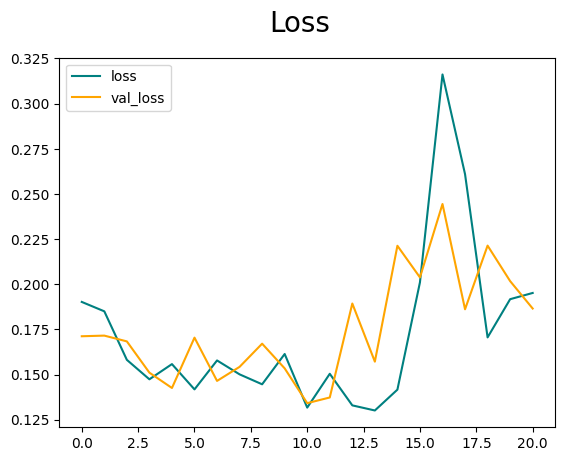

In [28]:
fig = plt.figure()
plt.plot(history.history['loss'], color = 'teal', label = 'loss')
plt.plot(history.history['val_loss'], color = 'orange', label='val_loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Plotting accuracy

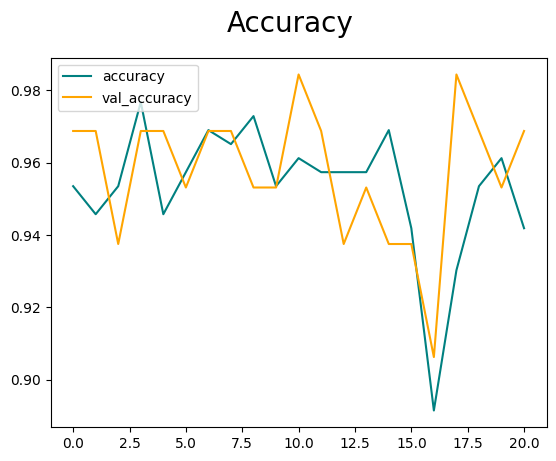

In [29]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label='val_accuracy')
plt.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Based on these two graphs, we can see that there are fluctuations in both accuracy and losses and the reason is because of the amount of data we have. Having 300 images to train a model is hard to reach maximum accuracy and minimum loss and therefore requires a lot more data and more GPU computations to speed up the computations. However, with my current Mac (along with its limitations) and the fact that our model yields an accuracy of 95.37% and loss of 0.23, it is impressive given the technology limitation. 

For fun, let's test our optimal model with two banana images with the first being ripe and the other unripe.

## Saving the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models', 'banana_ripeness_prediction.h5'))

## Conclusion

Throughout this project, I was able to learn the stages in creating and developing a neural network that could learn to predict the ripeness of any banana images. For our statistics, I was able to create a Covolutional Neural Network with a 95.37% accuracy level with a 22% loss. Though there can be more opportunity to optimize for this and reduce the loss level and icnrease the accuracy level by adding more data, this project serves as a good starting point for me to begin other neural-network projects!